# M3.3 Transformers



 In this notebook, we will explore the Transformer architecture, which has become the foundation for modern NLP models. We will cover the core mechanisms, implement simple experiments, and work with pre-trained models.

## 1. The Transformer Architecture

The Transformer architecture, introduced in "Attention is All You Need" (Vaswani et al., 2017), replaced recurrent architectures with a mechanism based entirely on attention. This allows for better parallelization and the ability to model long-range dependencies in text.

### 1.1 The Attention Mechanism
 At the core of transformers is the attention mechanism. Unlike previous architectures that processed sequences sequentially, attention allows the model to focus on different parts of the input simultaneously.

 The key idea is that for each position in a sequence, we compute how much attention to pay to every other position. This is done through three learned representations:


 - **Queries (Q)**: What we're looking for
 - **Keys (K)**: What each position offers
 - **Values (V)**: The actual information at each position



 <!-- ![Attention Mechanism](fig_showing_attention) -->

<p align="center">
    <img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/attention_example.svg" alt="attn_nn" style="max-width:50%;">
</p>
(img credits from uvadlc course)


 The attention score between a query and all keys is computed as:



 $$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$



 where $d_k$ is the dimension of the keys. The division by $\sqrt{d_k}$ prevents the dot products from growing too large, which would push the softmax into regions with very small gradients.

### 1.2 Multi-Head Attention (MHA)



 Rather than computing attention once, Multi-Head Attention runs multiple attention operations in parallel, each with different learned linear projections. This allows the model to attend to information from different representation subspaces.



 <!-- ![Multi-Head Attention](fig_showing_mha) -->
<p align="center">
    <img src="https://miro.medium.com/v2/1*jsR691rbi1-LmYTBHzjDMA.png" alt="fig_showing_mha" style="max-width:15%;">
</p>


 Each "head" learns to focus on different aspects of the relationships between tokens. For example, one head might learn syntactic dependencies while another learns semantic relationships.



 The outputs from all heads are concatenated and linearly transformed:



 $$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$



 where each head is computed as:



 $$\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$

### 1.3 Encoder-Decoder Architecture
 The original Transformer uses an encoder-decoder structure:

 <!-- ![Encoder-Decoder Architecture](fig_showing_enc_dec) -->
 <p align="center">
    <img src="https://heidloff.net/assets/img/2023/02/transformers.png" alt="fig_showing_mha" style="max-width:50%; background-color: white;">
</p>

 - **Encoder**: Processes the input sequence and builds a representation
 - **Decoder**: Generates the output sequence, attending to both its own previous outputs and the encoder's representations

 Modern models often use only the encoder (BERT) or only the decoder (GPT), depending on the task.

In [16]:
## ignore warning messages for cleaner output of the website
import warnings
warnings.filterwarnings('ignore')

## Import required libraries
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import math

from datasets import load_dataset

## 2. Toy Experiment: Next Token Prediction



 We'll implement a simple experiment to understand how transformers learn sequence patterns. We'll create a toy dataset and compare transformer models of different depths with n-gram baseline statistics.

### 2.1 Generate Toy Dataset



 We'll create a simple artificial language with predictable patterns.

In [2]:
dataset = load_dataset("imdb", split="train")  ## Subset for faster training
dataset = dataset.shuffle(seed=42)

len_data = 1000
train_data = dataset.select(range(len_data))["text"]
test_data = dataset.select(range(len_data, len_data*2))["text"]

In [3]:
def char_to_num(c):
    """ Our mapping a mapping function from character to number
         In this case: a=0, b=1, ..., z=25, space=26
    """
    if c == ' ':
        return 26
    return ord(c) - ord('a')

def process_texts(texts, N, char_to_num_fn):
    """
    Processes a list of texts by lowercasing, removing non-alphabetic characters, truncating to a fixed length, and mapping each character to a numeric value. 
    Returns a list of lists of mapped numbers for valid texts.
    """
    processed_nums = []
    for text in texts:
        text = text.lower() ## Convert to lowercase        
        text = re.sub(r'[^a-z ]', '', text)  ## Keep only a-z and space 
        

        ## if size is less than N, skip
        if len(text) < N:
            continue

        text = text[:N] ## Keep only the first N characters

        ## Convert each char to number using mapping function
        nums = [char_to_num_fn(c) for c in text]
        if any(n > 26 or n < 0 for n in nums):
            raise ValueError(f"Character mapping returned invalid number: {nums} - text: {text}")
        
        processed_nums.append(nums)
    return processed_nums

In [4]:
N = 50
train_data = process_texts(train_data, N, char_to_num)
test_data = process_texts(test_data, N, char_to_num)

### 2.2 N-gram Baseline



 Before using transformers, let's establish a baseline using n-gram statistics.

In [5]:
def build_ngram_model(data, n=3):
    """Build n-gram model from data - a """
    ngram_counts = {}
    
    for seq in data:
        for i in range(len(seq) - n):
            context = tuple(seq[i:i+n])
            next_token = seq[i+n]
            if context not in ngram_counts:
                ngram_counts[context] = Counter()
            ngram_counts[context][next_token] += 1
    
    return ngram_counts

def ngram_predict(ngram_model, context):
    """Predict next token given context"""
    context = tuple(context)
    if context in ngram_model:
        return ngram_model[context].most_common(1)[0][0]
    return np.random.randint(0, 10)  ## Random if context not seen

def evaluate_ngram(ngram_model, test_data, n=3, start_eval=3):
    """Evaluate n-gram model accuracy"""
    correct = 0
    total = 0
    
    for seq in test_data:
        for i in range(start_eval, len(seq)):
            context = seq[i-n:i]
            pred = ngram_predict(ngram_model, context)
            if pred == seq[i]:
                correct += 1
            total += 1
    
    return correct / total

In [6]:
## Build and evaluate n-gram models
trigram_model = build_ngram_model(train_data, n=3)
trigram_acc = evaluate_ngram(trigram_model, test_data, n=3, start_eval=3)

bigram_model = build_ngram_model(train_data, n=2)
bigram_acc = evaluate_ngram(bigram_model, test_data, n=2, start_eval=3)

print(f"Bigram accuracy: {bigram_acc*100:.1f} %")
print(f"Trigram accuracy: {trigram_acc*100:.1f} %")

Bigram accuracy: 42.0 %
Trigram accuracy: 50.7 %


### 2.3 Simple Transformer Model



 Now let's create transformer models with different numbers of layers using PyTorch.

In [7]:
class PositionalEncoding(nn.Module):
    """ 
    Positional Encoding module for Transformer models 
        -> We don't learn this but keep it fixed. It ensures that the model can distinguish token positions.
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  ## Shape: (1, max_len, d_model) for batch_first
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """ This function adds positional encoding to the input tensor x and retursns it."""
        ## x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]  ## Use seq_len (dimension 1)!
        return self.dropout(x)

In [8]:
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, num_layers=1, dim_feedforward=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=0.1, max_len=100)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model
        
    def forward(self, x):
        seq_len = x.size(1)
        
        ## Create causal mask
        causal_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(x.device)
        
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x, mask=causal_mask, is_causal=True)  ## Add causal mask!
        x = self.fc_out(x)
        return x

### 2.4 Training Function

In [9]:
def train_transformer(model, train_data, epochs=50, batch_size=32, lr=0.001):
    """Train transformer for next token prediction"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_tensor = torch.LongTensor(train_data)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        batch_count = 0
        acc_list = []
        
        ## Create batches
        indices = torch.randperm(len(train_tensor))
        for i in range(0, len(train_tensor), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch = train_tensor[batch_indices]
            
            ## Input is all tokens except last, target is all tokens except first
            input_seq = batch[:, :-1]
            target_seq = batch[:, 1:]
            
            optimizer.zero_grad()
            output = model(input_seq)  ## shape: (B, L, V)

            ## Calculate accuracy for this batch (optional, for monitoring)
            with torch.no_grad():
                preds = output.argmax(dim=-1)
                batch_acc = (preds == target_seq).float().mean().item()
                acc_list.append(batch_acc)
            
            ## Use actual vocabulary size from model output (avoid hard-coded value)
            vocab_dim = output.size(-1)
            loss = criterion(output.reshape(-1, vocab_dim), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1

        
        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / max(1, batch_count)
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f} , TrainAcc: {np.mean(acc_list)*100:.2f} %")

In [10]:
def evaluate_transformer(model, test_data, batch_size=64, start_eval=None):
    """Evaluate transformer accuracy (with optional start_eval for position masking)"""
    model.eval()
    device = next(model.parameters()).device
    test_tensor = torch.LongTensor(test_data).to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for start in range(0, len(test_tensor), batch_size):
            batch = test_tensor[start:start+batch_size]
            if batch.size(0) == 0:
                continue
            ## Predict all tokens except last, compare to all except first
            input_seq = batch[:, :-1]
            target_seq = batch[:, 1:]
            output = model(input_seq)
            preds = output.argmax(dim=-1)
            ## If start_eval is set, only evaluate from that position onwards
            if start_eval is not None:
                preds = preds[:, start_eval:]
                target_seq = target_seq[:, start_eval:]
            correct += (preds == target_seq).sum().item()
            total += target_seq.numel()
    return correct / total if total > 0 else 0.0

### 2.5 Compare Models with Different Depths

In [11]:
## Train models with 1, 2, and 3 layers (use dynamic vocab size derived from train_data)
results = {}

## Model hyperparameters
d_model = 128
nhead = 16

for num_layers in [1, 2, 3]:
    print(f"\n{'='*50}")
    print(f"Training {num_layers}-layer transformer")
    print('='*50)

    ## derive vocab size from training data to keep consistency
    vocab_size = int(max(max(seq) for seq in train_data) + 1)
    print(f"Vocab size: {vocab_size} - should be 27")
    model = SimpleTransformer(vocab_size=vocab_size, num_layers=num_layers, d_model=d_model, nhead=nhead)
    train_transformer(model, train_data, epochs=50, lr=0.003)
        
    accuracy = evaluate_transformer(model, test_data)
    results[f"{num_layers}-layer"] = accuracy
    print(f"\n{num_layers}-layer transformer accuracy: {accuracy:.4f}")


Training 1-layer transformer
Vocab size: 27 - should be 27
Epoch 10, Loss: 2.0020 , TrainAcc: 39.18 %
Epoch 20, Loss: 1.8737 , TrainAcc: 42.89 %
Epoch 30, Loss: 1.8062 , TrainAcc: 44.56 %
Epoch 40, Loss: 1.7606 , TrainAcc: 45.81 %
Epoch 50, Loss: 1.7232 , TrainAcc: 46.91 %

1-layer transformer accuracy: 0.4619

Training 2-layer transformer
Vocab size: 27 - should be 27
Epoch 10, Loss: 1.9082 , TrainAcc: 42.06 %
Epoch 20, Loss: 1.7523 , TrainAcc: 46.16 %
Epoch 30, Loss: 1.6541 , TrainAcc: 48.92 %
Epoch 40, Loss: 1.5901 , TrainAcc: 50.75 %
Epoch 50, Loss: 1.5352 , TrainAcc: 52.12 %

2-layer transformer accuracy: 0.4836

Training 3-layer transformer
Vocab size: 27 - should be 27
Epoch 10, Loss: 1.8779 , TrainAcc: 42.89 %
Epoch 20, Loss: 1.7079 , TrainAcc: 47.59 %
Epoch 30, Loss: 1.5884 , TrainAcc: 50.83 %
Epoch 40, Loss: 1.5026 , TrainAcc: 53.04 %
Epoch 50, Loss: 1.4363 , TrainAcc: 54.91 %

3-layer transformer accuracy: 0.4918


### 2.6 Results Comparison


ACCURACY COMPARISON
Bigram baseline:     0.4198
Trigram baseline:    0.5066
1-layer transformer: 0.4619
2-layer transformer: 0.4836
3-layer transformer: 0.4918


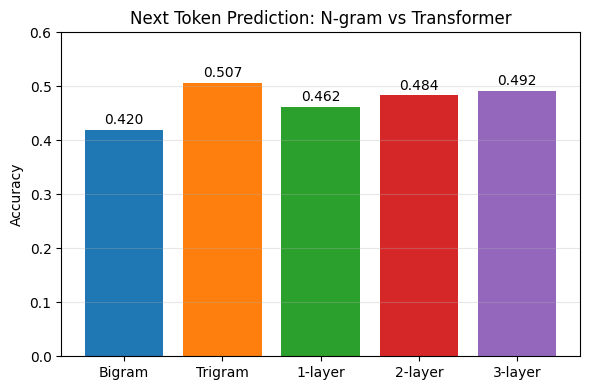

In [12]:
## Compare all models
print("\n" + "="*50)
print("ACCURACY COMPARISON")
print("="*50)
print(f"Bigram baseline:     {bigram_acc:.4f}")
print(f"Trigram baseline:    {trigram_acc:.4f}")
for name, acc in results.items():
    print(f"{name} transformer: {acc:.4f}")

## Visualization
labels = ['Bigram', 'Trigram'] + list(results.keys())
accuracies = [bigram_acc, trigram_acc] + list(results.values())

plt.figure(figsize=(6, 4))
plt.bar(labels, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylabel('Accuracy')
plt.title('Next Token Prediction: N-gram vs Transformer')
plt.ylim([0, 0.6])
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()


### 2.7 Text Generation Example



 Let's generate some sequences to see what the model has learned.

In [13]:
def generate_sequence(model, start_tokens, max_length=15):
    """Generate sequence from model"""
    model.eval()
    generated = start_tokens.copy()
    
    with torch.no_grad():
        for _ in range(max_length - len(start_tokens)):
            input_seq = torch.LongTensor([generated])
            output = model(input_seq)
            next_token = output[0, -1].argmax().item()
            generated.append(next_token)
    
    return generated

## Generate from the 3-layer model (use dynamic vocab size)
vocab_size = int(max(max(seq) for seq in train_data) + 1)
model_3layer = SimpleTransformer(vocab_size=vocab_size, num_layers=3, d_model=d_model, nhead=nhead)
train_transformer(model_3layer, train_data, epochs=50)

## Let's see what we have learned! 
start_strings = ["i am ", "my name is ", "i would never ", 'this ted talk is about ']

print("\nGenerated sequences (3-layer transformer):")
for start_str in start_strings:
    start = [char_to_num(c) for c in start_str]
    generated = generate_sequence(model_3layer, start, max_length=50)
    gen_str = ''.join(chr(n + ord('a')) if n < 26 else ' ' for n in generated)
    print(f"Start: '{start_str}' -> '{gen_str[len(start_str):]}'")
    print(f"Full:  '{start_str}{gen_str[len(start_str):]}'\n")


Epoch 10, Loss: 1.9913 , TrainAcc: 39.70 %
Epoch 20, Loss: 1.7754 , TrainAcc: 45.76 %
Epoch 30, Loss: 1.6459 , TrainAcc: 49.31 %
Epoch 40, Loss: 1.5519 , TrainAcc: 51.92 %
Epoch 50, Loss: 1.4765 , TrainAcc: 53.84 %

Generated sequences (3-layer transformer):
Start: 'i am ' -> 'was really for this film that is a a film is '
Full:  'i am was really for this film that is a a film is '

Start: 'my name is ' -> 'a the first of the beck what is a a bou'
Full:  'my name is a the first of the beck what is a a bou'

Start: 'i would never ' -> 'to seee this movie i was so the mad '
Full:  'i would never to seee this movie i was so the mad '

Start: 'this ted talk is about ' -> 'the movie i was a can and a'
Full:  'this ted talk is about the movie i was a can and a'



## 3. Pre-trained Models: BERT and GPT



 Now let's work with real pre-trained transformer models using the HuggingFace Transformers library.

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch.nn.functional as F

### 3.1 BERT: Masked Language Modeling



 BERT (Bidirectional Encoder Representations from Transformers) is an encoder-only model trained on masked language modeling. It can see the entire context (both left and right) when predicting masked tokens.

In [ ]:
def predict_masked_token(text, model, tokenizer, top_k=5):
    """Predict masked tokens in text"""
    ## Tokenize
    inputs = tokenizer(text, return_tensors='pt')
    
    ## Find mask position
    mask_token_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
    
    ## Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits
    
    ## Get top-k predictions for masked position
    mask_predictions = predictions[0, mask_token_index, :]
    top_tokens = torch.topk(mask_predictions, top_k, dim=1)
    
    print(f"Text: {text}")
    print(f"\nTop {top_k} predictions:")
    for i, (token_id, score) in enumerate(zip(top_tokens.indices[0], top_tokens.values[0])):
        token = tokenizer.decode([token_id])
        prob = F.softmax(mask_predictions, dim=1)[0, token_id].item()
        print(f"{i+1}. {token:15s} (probability: {prob:.4f})")
    print()

In [ ]:
## Load BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
bert_model.eval()

## Test BERT on various examples
print("="*60)
print("BERT: Masked Language Modeling")
print("="*60)

predict_masked_token("The capital of France is [MASK].", bert_model, bert_tokenizer)
predict_masked_token("The cat sat on the [MASK].", bert_model, bert_tokenizer)
predict_masked_token("Natural [MASK] Processing is a subfield of AI.", bert_model, bert_tokenizer)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT: Masked Language Modeling
Text: The capital of France is [MASK].

Top 5 predictions:
1. paris           (probability: 0.4168)
2. lille           (probability: 0.0714)
3. lyon            (probability: 0.0634)
4. marseille       (probability: 0.0444)
5. tours           (probability: 0.0303)

Text: The cat sat on the [MASK].

Top 5 predictions:
1. floor           (probability: 0.3145)
2. bed             (probability: 0.1190)
3. couch           (probability: 0.1070)
4. sofa            (probability: 0.0603)
5. ground          (probability: 0.0551)

Text: Natural [MASK] Processing is a subfield of AI.

Top 5 predictions:
1. language        (probability: 0.7656)
2. information     (probability: 0.0450)
3. signal          (probability: 0.0251)
4. resource        (probability: 0.0211)
5. data            (probability: 0.0103)



### 3.2 BERT for Text Classification

In [ ]:
from tqdm import tqdm

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
dataset = load_dataset("imdb", split="train")  ## Subset for faster training
dataset = dataset.shuffle(seed=42)

len_data = 10000
data_subset = dataset.select(range(len_data))

## split data into train and test using hugginface datasets functionalities
split = data_subset.train_test_split(test_size=0.7, seed=42)
train_txt = split['train']['text']
test_txt = split['test']['text']

train_labels = split['train']['label']
test_labels = split['test']['label']

In [ ]:
class BERTClassifier(pl.LightningModule):
    def __init__(self, num_labels=2, freeze_bert=True, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
        
        ## Freeze BERT encoder
        if freeze_bert:
            for param in self.model.bert.parameters():
                param.requires_grad = False
        
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        outputs = self(input_ids, attention_mask)
        loss = self.loss_fn(outputs.logits, labels)
        
        preds = outputs.logits.argmax(dim=1)
        acc = (preds == labels).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        outputs = self(input_ids, attention_mask)
        loss = self.loss_fn(outputs.logits, labels)
        
        preds = outputs.logits.argmax(dim=1)
        acc = (preds == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}
    
    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        outputs = self(input_ids, attention_mask)
        loss = self.loss_fn(outputs.logits, labels)
        
        preds = outputs.logits.argmax(dim=1)
        acc = (preds == labels).float().mean()
        
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.classifier.parameters(), lr=self.hparams.lr)

In [ ]:
def train_bert_classifier(train_loader, test_loader, epochs=2, lr=2e-4,
                          num_labels=2, use_gpu=True, freeze_bert=True):
    """
    Train a BERT text classifier with frozen encoder.
    
    Args:
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        epochs: Number of training epochs
        lr: Learning rate
        num_labels: Number of output classes
        use_gpu: Whether to use GPU if available
    
    Returns:
        Trained model
    """

    
    ## Initialize model
    model = BERTClassifier(num_labels=num_labels, freeze_bert=freeze_bert)
    
    ## Trainer with optimizations
    trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator='gpu' if use_gpu and torch.cuda.is_available() else 'cpu',
        precision='16-mixed' if use_gpu and torch.cuda.is_available() else 32,  ## Mixed precision for speed
        gradient_clip_val=1.0,
        log_every_n_steps=10,
        enable_checkpointing=False,
        logger=False  ## Disable default logger for simplicity
    )
    
    ## Train
    trainer.fit(model, train_loader, test_loader)
    
    ## Test
    test_results = trainer.test(model, test_loader)
    ## print(f"\nFinal Test Accuracy: {test_results[0]['val_acc']:.3f}")
    print(f"\nFinal Test Accuracy: {test_results[0]['test_acc']:.3f}")
    return model

def prepare_data(train_txt, train_labels, test_txt, test_labels, max_length=64, batch_size=16):

        ## Tokenize
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_enc = tokenizer(train_txt, truncation=True, padding='max_length', 
                         max_length=max_length, return_tensors='pt')
    test_enc = tokenizer(test_txt, truncation=True, padding='max_length',
                        max_length=max_length, return_tensors='pt')
    
    ## Create datasets
    train_dataset = TensorDataset(train_enc['input_ids'], train_enc['attention_mask'], 
                                  torch.tensor(train_labels))
    test_dataset = TensorDataset(test_enc['input_ids'], test_enc['attention_mask'],
                                torch.tensor(test_labels))
    
    ## DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4,
                            pin_memory=True)

    return train_loader, test_loader



In [ ]:
train_loader, test_loader = prepare_data(
    train_txt, train_labels, test_txt, test_labels, max_length=64, batch_size=16
)


In [ ]:
model = train_bert_classifier(
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=5,
    lr=1e-5,
    freeze_bert=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 2000 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                          | Params | Mode 
-------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6324285864830017     │
│         test_loss         │    0.6442899107933044     │
└───────────────────────────┴───────────────────────────┘


Final Test Accuracy: 0.632


### 3.2 GPT: Text Generation
 GPT (Generative Pre-trained Transformer) is a decoder-only model trained on causal language modeling. It can only see the left context when predicting the next token, making it suitable for text generation.
 One of the most popular AI models today, ChatGPT, is a type of Transformer Decoder.
 As you might have noticed when we generate text via a Decoder this is relatively slow. The reason for this is that for every "forward pass", the model only predicts the next token, which we then feed back to the input and make it predict the following token. In the example image below we start with an input we provide "Hello, my name", which are all fed to the input to predict the next token, where the model says " is". Now for the next word we need to feed the string "Hello, my name is" to the model, so it predicts " James". As you can see this takes a lot of iterations through the model. Through clever computing we can store some of the matrix multiplications that are happening inside the model so when we run `model.generate()` we don't have to redo the computations we could already store when we predicted previous tokens. 



 <p align="center">
    <img src="https://www.researchgate.net/publication/363765406/figure/fig1/AS:11431281085833161@1663902465850/llustration-of-transformer-based-text-generation.png" alt="gpt_generation" style="max-width:50%;">
</p>

In [ ]:
def generate_text_gpt(prompt, model, tokenizer, max_length=50, temperature=0.7):
    """Generate text from prompt"""
    inputs = tokenizer(prompt, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model.generate(
            inputs['input_ids'],
            max_length=max_length,
            temperature=temperature,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

In [ ]:
## Load GPT-2 model and tokenizer
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt_model.eval()

## Set pad token (GPT2 doesn't have one by default)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token


## Test GPT on various prompts
print("="*60)
print("GPT-2: Text Generation")
print("="*60)

prompts = [
    "Natural language processing is",
    "The transformer architecture revolutionized",
    "In the field of linguistics,"
]

for prompt in prompts:
    print(f"\nPrompt: {prompt}")
    print(f"Generated: {generate_text_gpt(prompt, gpt_model, gpt_tokenizer, max_length=40)}")
    print("-" * 60)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


GPT-2: Text Generation

Prompt: Natural language processing is
Generated: Natural language processing is a powerful and valuable tool in the development of languages, but it is still limited to languages that are easy to understand and understand.

There are currently no native languages that can
------------------------------------------------------------

Prompt: The transformer architecture revolutionized
Generated: The transformer architecture revolutionized the way we make the electrical system. The power grid can be made of a single or multiple pieces of wire, but they all have a common core. The transformer's core
------------------------------------------------------------

Prompt: In the field of linguistics,
Generated: In the field of linguistics, we often get the impression that language is more like a language than an object. As a result, we often get the impression that language is more like a language than
------------------------------------------------------------


### 3.3 Key Differences: BERT vs GPT

 | Aspect | BERT | GPT |
 |--------|------|-----|
 | Architecture | Encoder-only | Decoder-only |
 | Attention | Bidirectional | Causal (left-to-right) |
 | Training Task | Masked Language Modeling | Next Token Prediction |
 | Best For | Understanding tasks (classification, NER) | Generation tasks |
 | Context | Sees full sentence | Sees only previous tokens |

## 4. Summary
 In this notebook, we explored:
 1. **Attention Mechanism**: The core innovation that allows transformers to weigh the importance of different parts of the input
 2. **Multi-Head Attention**: Running multiple attention operations in parallel to capture different types of relationships
 3. **Toy Experiments**: How transformers of different depths compare to n-gram baselines on next token prediction
 4. **Pre-trained Models**:
    - BERT for bidirectional context understanding (masked language modeling)
    - GPT for text generation (causal language modeling)

## References
 - Vaswani et al. (2017). "Attention is All You Need". NeurIPS.
 - Devlin et al. (2018). "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding". NAACL.
 - Radford et al. (2019). "Language Models are Unsupervised Multitask Learners" (GPT-2).